<a href="https://colab.research.google.com/github/ksahil22/smart-intrusion-detection-system/blob/main/AI_IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

TRAIN_PATH = '/content/KDDTrain+.txt'
TEST_PATH  = '/content/KDDTest+.txt'


raw_train = pd.read_csv(TRAIN_PATH, header=None)
raw_test  = pd.read_csv(TEST_PATH,  header=None)

print("Raw train shape:", raw_train.shape)
print("Raw test shape: ", raw_test.shape)


# Base 41 feature names + 'label'
base_cols = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land',
    'wrong_fragment','urgent','hot','num_failed_logins','logged_in',
    'num_compromised','root_shell','su_attempted','num_root',
    'num_file_creations','num_shells','num_access_files','num_outbound_cmds',
    'is_host_login','is_guest_login','count','srv_count','serror_rate',
    'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
    'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
    'dst_host_same_srv_rate','dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
    'dst_host_serror_rate','dst_host_srv_serror_rate',
    'dst_host_rerror_rate','dst_host_srv_rerror_rate',
    'label'
]

# Calculate how many extra columns beyond the 42 we have
extra = raw_train.shape[1] - len(base_cols)
if extra > 0:
    # name them extra_1, extra_2, ...
    base_cols += [f'extra_{i+1}' for i in range(extra)]

# Assign to both DataFrames
raw_train.columns = base_cols
raw_test.columns  = base_cols


# Export the raw DataFrame (with column names) to CSV
raw_train.to_csv('raw_train_with_headers.csv', index=False)
raw_test .to_csv('raw_test_with_headers.csv',  index=False)

# Download to local machine
# from google.colab import files
# files.download('raw_train_with_headers.csv')
# files.download('raw_test_with_headers.csv')

print("Assigned columns:", len(base_cols), "=>", base_cols[-(extra+5):])  # show last few


# Remove duplicates
raw_train.drop_duplicates(inplace=True)
raw_test.drop_duplicates(inplace=True)

# Droping any extra columns beyond 'label'
to_drop = [c for c in raw_train.columns if c.startswith('extra_')]
raw_train.drop(columns=to_drop, inplace=True)
raw_test .drop(columns=to_drop, inplace=True)

# Droping any NaNs
raw_train.dropna(inplace=True)
raw_test .dropna(inplace=True)


#Reduceing the 'service' Cardinality (top 20 + other)

top_services = raw_train['service'].value_counts().nlargest(20).index
for df in (raw_train, raw_test):
    df['service'] = df['service'].where(df['service'].isin(top_services), other='other')


df_train = raw_train.sample(n=50000, random_state=42).reset_index(drop=True)
df_test  = raw_test.copy().reset_index(drop=True)
print("After sampling, train shape:", df_train.shape, "; test shape:", df_test.shape)



#One‑Hot Encode Categorical Features

cat_cols = ['protocol_type','service','flag']
df_train = pd.get_dummies(df_train, columns=cat_cols)
df_test  = pd.get_dummies(df_test,  columns=cat_cols)

# Aligning columns (fill missing dummies with 0)
df_train, df_test = df_train.align(df_test, join='outer', axis=1, fill_value=0)


#Label‑Encode the Target

# ─── Binary‐Encode the Target: 0=normal, 1=attack ───
df_train['label'] = (df_train['label'] != 'normal').astype(int)
df_test ['label'] = (df_test ['label'] != 'normal').astype(int)

print("Train label distribution:\n", df_train['label'].value_counts())
print("Test  label distribution:\n", df_test ['label'].value_counts())


#Split Features & Target

X_train = df_train.drop('label', axis=1)
y_train = df_train['label']
X_test  = df_test .drop('label', axis=1)
y_test  = df_test ['label']


#Ensure Numeric & Handle Any Coercion

X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test  = X_test .apply(pd.to_numeric, errors='coerce')
X_train.fillna(0, inplace=True)
X_test .fillna(0, inplace=True)


# Scaling Features

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


print("Preprocessing complete!")
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_test  shape:", X_test.shape,  "y_test  shape:", y_test.shape)



# Save & Download Processed Data

# Combine X and y back into single DataFrames for CSV export
# processed_train = X_train.copy()
# processed_train['label'] = y_train

# processed_test = X_test.copy()
# processed_test['label'] = y_test

# # Save to CSV
# processed_train.to_csv('processed_train.csv', index=False)
# processed_test .to_csv('processed_test.csv',  index=False)

# # Download via Colab
# from google.colab import files
# files.download('processed_train.csv')
# files.download('processed_test.csv')

Raw train shape: (125973, 43)
Raw test shape:  (22544, 43)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Assigned columns: 43 => ['dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'extra_1']
After sampling, train shape: (50000, 42) ; test shape: (22544, 42)
Train label distribution:
 label
0    26604
1    23396
Name: count, dtype: int64
Test  label distribution:
 label
1    12833
0     9711
Name: count, dtype: int64
Preprocessing complete!
X_train shape: (50000, 72) y_train shape: (50000,)
X_test  shape: (22544, 72) y_test  shape: (22544,)


## **Model Training & Evaluation**

In [2]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=100, max_depth=10, n_jobs=-1, random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100, max_depth=6, use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=100, max_depth=10, n_jobs=-1, random_state=42
    )
}

results = {}

# Train & evaluate each
for name, model in models.items():
    print(f"\n>>> Training {name}...")
    model.fit(X_train, y_train)

    print(f">>> Predicting with {name} on test set...")
    y_pred = model.predict(X_test)

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

    print(f"{name} Results:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1-score : {f1:.4f}")

    # Saving the models
    joblib.dump(model, f"{name.lower()}_model.joblib")
    print(f"Saved {name} to {name.lower()}_model.joblib")

# Summary Table
import pandas as pd
df_results = pd.DataFrame(results).T
df_results = df_results[['accuracy','precision','recall','f1']]  # reorder
print("\n=== Model Comparison ===")
print(df_results)



>>> Training RandomForest...
>>> Predicting with RandomForest on test set...
RandomForest Results:
  Accuracy : 0.7627
  Precision: 0.9666
  Recall   : 0.6041
  F1-score : 0.7435
Saved RandomForest to randomforest_model.joblib

>>> Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:04:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


>>> Predicting with XGBoost on test set...
XGBoost Results:
  Accuracy : 0.7897
  Precision: 0.9682
  Recall   : 0.6521
  F1-score : 0.7793
Saved XGBoost to xgboost_model.joblib

>>> Training LightGBM...
[LightGBM] [Info] Number of positive: 23396, number of negative: 26604
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3032
[LightGBM] [Info] Number of data points in the train set: 50000, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467920 -> initscore=-0.128497
[LightGBM] [Info] Start training from score -0.128497
>>> Predicting with LightGBM on test set...
LightGBM Results:
  Accuracy : 0.7812
  Precision: 0.9688
  Recall   : 0.6362
  F1-score : 0.7680
Saved LightGBM to lightgbm_model.joblib

=== Model Comparison ===
              accuracy  precis

In [5]:
import time
import joblib
import numpy as np
import warnings

warnings.filterwarnings("ignore")

MODEL_PATH = 'randomforest_model.joblib'    # adjust if using XGBoost or LightGBM
STREAM_CAP  = 1000                          # max number of samples to process
DELAY_SEC   = 0.05                          # pause (seconds) between samples
PRINT_EVERY = 100                           # print progress every PRINT_EVERY samples

# Load Model
model = joblib.load(MODEL_PATH)
print(f"Loaded model from {MODEL_PATH}")

# Streaming Simulation
print(f"\nStarting streaming demo (up to {STREAM_CAP} samples, {DELAY_SEC}s delay):\n")
alert_count = 0

for i, (idx, sample) in enumerate(X_test.iterrows(), start=1):
    if i > STREAM_CAP:
        break

    # Predict single sample
    pred = model.predict(sample.values.reshape(1, -1))[0]

    # If attack, print alert
    if pred == 1:
        alert_count += 1
        ts = time.strftime('%Y-%m-%d %H:%M:%S')
        print(f"[{ts}] ALERT #{alert_count}: Attack detected at test idx {idx} (stream #{i})")

    # Optional: print heartbeat
    if i % PRINT_EVERY == 0:
        print(f"...processed {i} samples so far (alerts: {alert_count})")

    # Delay to mimic live stream
    time.sleep(DELAY_SEC)

print(f"\nStreaming demo complete. Processed {i} samples, total alerts: {alert_count}.")


Loaded model from randomforest_model.joblib

Starting streaming demo (up to 1000 samples, 0.05s delay):

[2025-05-20 22:05:32] ALERT #1: Attack detected at test idx 0 (stream #1)
[2025-05-20 22:05:32] ALERT #2: Attack detected at test idx 1 (stream #2)
[2025-05-20 22:05:33] ALERT #3: Attack detected at test idx 3 (stream #4)
[2025-05-20 22:05:33] ALERT #4: Attack detected at test idx 12 (stream #13)
[2025-05-20 22:05:33] ALERT #5: Attack detected at test idx 13 (stream #14)
[2025-05-20 22:05:34] ALERT #6: Attack detected at test idx 19 (stream #20)
[2025-05-20 22:05:34] ALERT #7: Attack detected at test idx 20 (stream #21)
[2025-05-20 22:05:34] ALERT #8: Attack detected at test idx 21 (stream #22)
[2025-05-20 22:05:34] ALERT #9: Attack detected at test idx 24 (stream #25)
[2025-05-20 22:05:34] ALERT #10: Attack detected at test idx 25 (stream #26)
[2025-05-20 22:05:35] ALERT #11: Attack detected at test idx 28 (stream #29)
[2025-05-20 22:05:35] ALERT #12: Attack detected at test idx 33

In [6]:
import csv
import os

ALERTS_CSV = 'stream_alerts.csv'
COUNTS_CSV = 'stream_counts.csv'

# Removing old logs if they exist
for f in (ALERTS_CSV, COUNTS_CSV):
    if os.path.exists(f):
        os.remove(f)

# Writing headers
with open(ALERTS_CSV, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['stream_idx','test_idx','timestamp','prediction'])  # 0=normal,1=attack

with open(COUNTS_CSV, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['processed','cumulative_normal','cumulative_attack'])


Starting streaming up to 1000 samples...

[2025-05-20 23:03:09] ALERT #1: Attack @ idx 0 (stream #1)
[2025-05-20 23:03:09] ALERT #2: Attack @ idx 1 (stream #2)
[2025-05-20 23:03:10] ALERT #3: Attack @ idx 3 (stream #4)
[2025-05-20 23:03:10] ALERT #4: Attack @ idx 12 (stream #13)
[2025-05-20 23:03:10] ALERT #5: Attack @ idx 13 (stream #14)
[2025-05-20 23:03:11] ALERT #6: Attack @ idx 19 (stream #20)
[2025-05-20 23:03:11] ALERT #7: Attack @ idx 20 (stream #21)
[2025-05-20 23:03:11] ALERT #8: Attack @ idx 21 (stream #22)
[2025-05-20 23:03:11] ALERT #9: Attack @ idx 24 (stream #25)
[2025-05-20 23:03:11] ALERT #10: Attack @ idx 25 (stream #26)
[2025-05-20 23:03:12] ALERT #11: Attack @ idx 28 (stream #29)
[2025-05-20 23:03:12] ALERT #12: Attack @ idx 33 (stream #34)
[2025-05-20 23:03:12] ALERT #13: Attack @ idx 34 (stream #35)
[2025-05-20 23:03:13] ALERT #14: Attack @ idx 40 (stream #41)
[2025-05-20 23:03:13] ALERT #15: Attack @ idx 44 (stream #45)
[2025-05-20 23:03:13] ALERT #16: Attack @ i

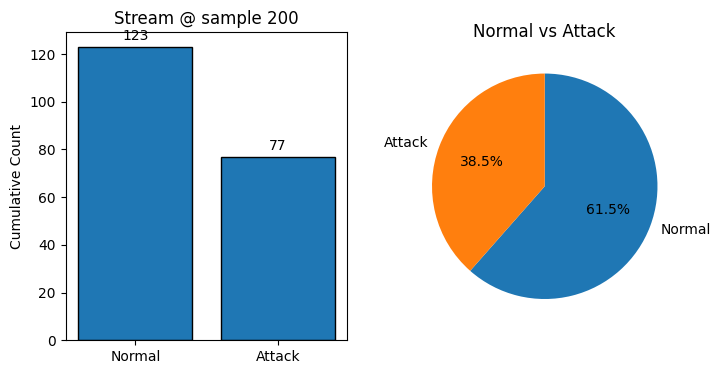

[2025-05-20 23:03:26] ALERT #78: Attack @ idx 205 (stream #206)
[2025-05-20 23:03:26] ALERT #79: Attack @ idx 206 (stream #207)
[2025-05-20 23:03:27] ALERT #80: Attack @ idx 215 (stream #216)
[2025-05-20 23:03:28] ALERT #81: Attack @ idx 223 (stream #224)
[2025-05-20 23:03:28] ALERT #82: Attack @ idx 225 (stream #226)
[2025-05-20 23:03:28] ALERT #83: Attack @ idx 227 (stream #228)
[2025-05-20 23:03:29] ALERT #84: Attack @ idx 234 (stream #235)
[2025-05-20 23:03:29] ALERT #85: Attack @ idx 235 (stream #236)
[2025-05-20 23:03:29] ALERT #86: Attack @ idx 243 (stream #244)
[2025-05-20 23:03:29] ALERT #87: Attack @ idx 244 (stream #245)
[2025-05-20 23:03:30] ALERT #88: Attack @ idx 247 (stream #248)
[2025-05-20 23:03:30] ALERT #89: Attack @ idx 248 (stream #249)
[2025-05-20 23:03:30] ALERT #90: Attack @ idx 254 (stream #255)
[2025-05-20 23:03:30] ALERT #91: Attack @ idx 255 (stream #256)
[2025-05-20 23:03:30] ALERT #92: Attack @ idx 256 (stream #257)
[2025-05-20 23:03:31] ALERT #93: Attack 

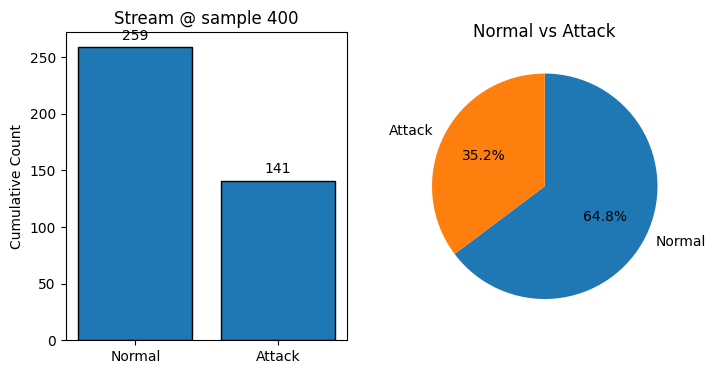

[2025-05-20 23:03:43] ALERT #142: Attack @ idx 400 (stream #401)
[2025-05-20 23:03:43] ALERT #143: Attack @ idx 403 (stream #404)
[2025-05-20 23:03:43] ALERT #144: Attack @ idx 405 (stream #406)
[2025-05-20 23:03:43] ALERT #145: Attack @ idx 409 (stream #410)
[2025-05-20 23:03:44] ALERT #146: Attack @ idx 411 (stream #412)
[2025-05-20 23:03:44] ALERT #147: Attack @ idx 413 (stream #414)
[2025-05-20 23:03:44] ALERT #148: Attack @ idx 416 (stream #417)
[2025-05-20 23:03:44] ALERT #149: Attack @ idx 417 (stream #418)
[2025-05-20 23:03:44] ALERT #150: Attack @ idx 420 (stream #421)
[2025-05-20 23:03:45] ALERT #151: Attack @ idx 423 (stream #424)
[2025-05-20 23:03:45] ALERT #152: Attack @ idx 425 (stream #426)
[2025-05-20 23:03:45] ALERT #153: Attack @ idx 426 (stream #427)
[2025-05-20 23:03:45] ALERT #154: Attack @ idx 427 (stream #428)
[2025-05-20 23:03:45] ALERT #155: Attack @ idx 428 (stream #429)
[2025-05-20 23:03:45] ALERT #156: Attack @ idx 430 (stream #431)
[2025-05-20 23:03:46] ALE

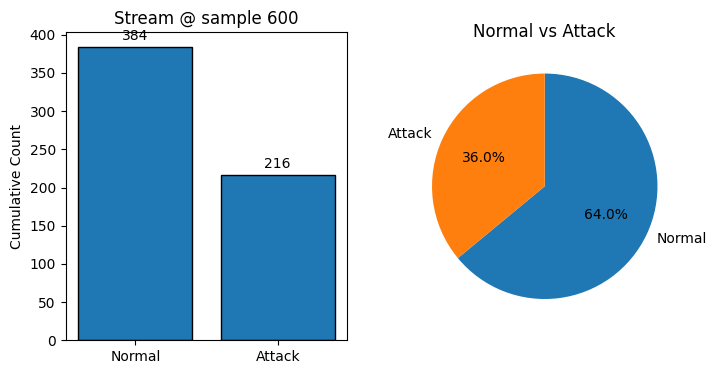

[2025-05-20 23:04:00] ALERT #217: Attack @ idx 601 (stream #602)
[2025-05-20 23:04:00] ALERT #218: Attack @ idx 603 (stream #604)
[2025-05-20 23:04:00] ALERT #219: Attack @ idx 604 (stream #605)
[2025-05-20 23:04:00] ALERT #220: Attack @ idx 606 (stream #607)
[2025-05-20 23:04:00] ALERT #221: Attack @ idx 609 (stream #610)
[2025-05-20 23:04:00] ALERT #222: Attack @ idx 610 (stream #611)
[2025-05-20 23:04:00] ALERT #223: Attack @ idx 611 (stream #612)
[2025-05-20 23:04:01] ALERT #224: Attack @ idx 613 (stream #614)
[2025-05-20 23:04:01] ALERT #225: Attack @ idx 615 (stream #616)
[2025-05-20 23:04:01] ALERT #226: Attack @ idx 616 (stream #617)
[2025-05-20 23:04:01] ALERT #227: Attack @ idx 618 (stream #619)
[2025-05-20 23:04:01] ALERT #228: Attack @ idx 620 (stream #621)
[2025-05-20 23:04:01] ALERT #229: Attack @ idx 623 (stream #624)
[2025-05-20 23:04:02] ALERT #230: Attack @ idx 627 (stream #628)
[2025-05-20 23:04:02] ALERT #231: Attack @ idx 628 (stream #629)
[2025-05-20 23:04:02] ALE

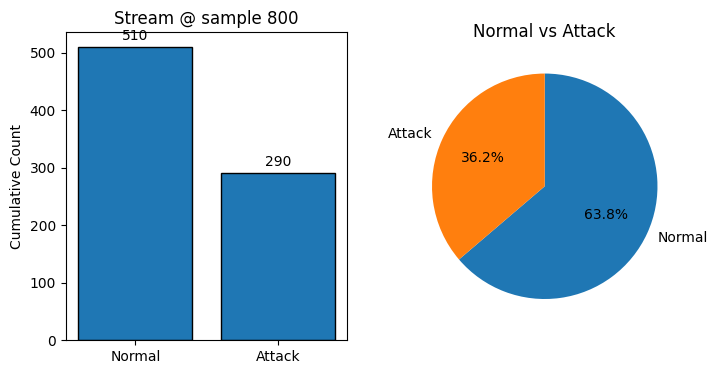

[2025-05-20 23:04:17] ALERT #291: Attack @ idx 801 (stream #802)
[2025-05-20 23:04:17] ALERT #292: Attack @ idx 803 (stream #804)
[2025-05-20 23:04:17] ALERT #293: Attack @ idx 809 (stream #810)
[2025-05-20 23:04:18] ALERT #294: Attack @ idx 820 (stream #821)
[2025-05-20 23:04:18] ALERT #295: Attack @ idx 821 (stream #822)
[2025-05-20 23:04:19] ALERT #296: Attack @ idx 825 (stream #826)
[2025-05-20 23:04:19] ALERT #297: Attack @ idx 828 (stream #829)
[2025-05-20 23:04:19] ALERT #298: Attack @ idx 829 (stream #830)
[2025-05-20 23:04:20] ALERT #299: Attack @ idx 840 (stream #841)
[2025-05-20 23:04:20] ALERT #300: Attack @ idx 843 (stream #844)
[2025-05-20 23:04:21] ALERT #301: Attack @ idx 854 (stream #855)
[2025-05-20 23:04:21] ALERT #302: Attack @ idx 855 (stream #856)
[2025-05-20 23:04:21] ALERT #303: Attack @ idx 857 (stream #858)
[2025-05-20 23:04:21] ALERT #304: Attack @ idx 858 (stream #859)
[2025-05-20 23:04:21] ALERT #305: Attack @ idx 859 (stream #860)
[2025-05-20 23:04:22] ALE

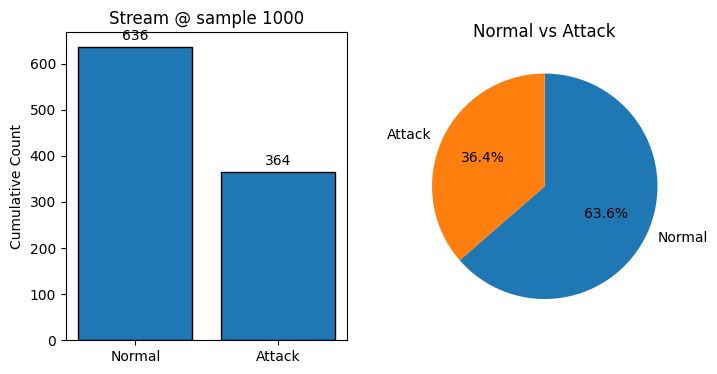


Demo complete: processed 1001 samples — Normal: 636, Attack: 364
Alerts saved to stream_alerts.csv
Counts saved to stream_counts.csv


In [9]:
import pandas as pd
import time
import joblib
from IPython.display import display
import matplotlib.pyplot as plt

MODEL_PATH  = 'randomforest_model.joblib'
STREAM_CAP  = 1000
DELAY_SEC   = 0.05
PRINT_EVERY = 200

# Load model
model = joblib.load(MODEL_PATH)

# Prepare empty DataFrames
alerts_df = pd.DataFrame(columns=['stream_idx','test_idx','timestamp','prediction'])
counts_df = pd.DataFrame(columns=['processed','cumulative_normal','cumulative_attack'])

# Counters
cum_norm = cum_atk = 0
x_vals, norm_counts, atk_counts = [], [], []

print(f"Starting streaming up to {STREAM_CAP} samples...\n")

for i, (idx, sample) in enumerate(X_test.iterrows(), start=1):
    if i > STREAM_CAP:
        break

    # Predict
    pred = model.predict(sample.values.reshape(1, -1))[0]
    ts   = time.strftime('%Y-%m-%d %H:%M:%S')

    # Append to alerts_df
    alerts_df.loc[len(alerts_df)] = [i, idx, ts, pred]

    # Update counters
    if pred == 1:
        cum_atk += 1
        print(f"[{ts}] ALERT #{cum_atk}: Attack @ idx {idx} (stream #{i})")
    else:
        cum_norm += 1

    # Every PRINT_EVERY, snapshot counts
    if (i % PRINT_EVERY == 0) or (i == STREAM_CAP):
        # Append to counts_df
        counts_df.loc[len(counts_df)] = [i, cum_norm, cum_atk]

        # Draw bar + pie as before
        fig, (ax_bar, ax_pie) = plt.subplots(1, 2, figsize=(8, 4))
        categories = ['Normal', 'Attack']
        counts     = [cum_norm, cum_atk]
        bars = ax_bar.bar(categories, counts, edgecolor='k')
        ax_bar.set_ylabel('Cumulative Count')
        ax_bar.set_title(f'Stream @ sample {i}')
        for bar in bars:
            ax_bar.annotate(f'{bar.get_height()}',
                            xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                            xytext=(0,3), textcoords='offset points',
                            ha='center', va='bottom')
        ax_pie.pie(counts, labels=categories, autopct='%1.1f%%',
                   startangle=90, counterclock=False)
        ax_pie.set_title('Normal vs Attack')
        display(fig)
        plt.close(fig)

    time.sleep(DELAY_SEC)

print(f"\nDemo complete: processed {i} samples — Normal: {cum_norm}, Attack: {cum_atk}")
print(f"Alerts saved to {ALERTS_CSV}")
print(f"Counts saved to {COUNTS_CSV}")
